# REDES NEURONALES PROFUNDAS
Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:

1. Entrenamiento de un perceptrón multicapa.
2. Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.
3. Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse lasprimeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).

Para los puntos 2) y 3) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

## OBJETIVO
Aplicar el proceso de aprendizaje a partir de datos para resolver problemas de clasificación utilizando redes neuronales profundas, sobre la herramienta Keras.

## DATOS
Incluidos en Keras.
Tambien, existe otra fuente equivalente que se consigue en el siguiente URL https://www.kaggle.com/zalando-research/fashionmnist donde hay un resumen de estos datos en el archivo CVS y XLSX.

la clasificacion para el aprendizaje supervisado es:

    Label 	Class
    0 	 	T-shirt/top
    1 	 	Trouser
    2 	 	Pullover
    3 	 	Dress
    4 	 	Coat
    5 	 	Sandal
    6 	 	Shirt
    7 	 	Sneaker
    8 	 	Bag
    9 	 	Ankle boot

**Importante: justifique cada decisión tomada y presente un análisis de los resultados obtenidos.**
### Consideraciones
- Utilice sólo los conjuntos de datos que se indican.
- El frameworks a utilizar es Keras con Jupyter Notebbooks.
- El taller debe ser realizado en grupos de tres personas.
- Entregables: archivos ipynb (comentados, con la justificación de las decisiones consideradas y análisis de resultados).

### Enlaces de Interes
- Ejemplos de Talos https://nbviewer.jupyter.org/github/autonomio/talos/tree/master/examples/
- Articulo sobre el uso de Talos https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
- Portal oficial de Talos https://autonomio.github.io/docs_talos/#introduction
- Github Talos https://github.com/autonomio/talos/tree/master/talos/scan
- Documentacion de github Talos https://github.com/autonomio/talos/tree/master/docs
- Documentacion Keras https://keras.io/models/sequential/

In [1]:
# importando dependencias de trabajo
# se importa OS, pandas y numpy para leer y preparar datos
import os
from collections import OrderedDict
from collections import Counter
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import pandas_profiling as profile
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras

# los modelos de aprendizaje con las diferentes librerias
import talos
from keras.layers import Input
from keras.layers import Flatten
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# otras librerias para manejo de experimentos, pruebas, optimizacion y otros
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### Cargar archivos
Para cargar los datos necesarios se siguen los siguientes pasos:

 - Se cargan los datos desde el conjunto de datos incluido en Keras

 - Se crean diccionarios de referencia para el pruebas y entrenamiento.
 - Se leen los arhivos de pruebas y entrenamiento para crear un set de datos.
 - Se transforma cada uno de los archivos en matrices de datos y se adicionan a los conjuntos de pruebas y entrenamiento.

In [2]:
# lista de nombres de las clasificaciones
classNamesList = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [3]:
# se carga el archivo de datos de trabajo por medio de Keras
fashionSource = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashionSource.load_data()

In [4]:
# nombres de columnas para el dataframe de pandas
columns = ["ID", "Data", "ReshapeData", "Label", "Class", "DataSize", "ReshapeSize", "ResKeras", "ScoreKeras"]
X_Data = np.concatenate((X_train, X_test), axis = 0)
y_Data = np.concatenate((y_train, y_test), axis = 0)

In [5]:
# puedo hacer otra forma de aprendizaje reorganizando los grupos de prueba y entrenamiento para ver si existe algun cambio de comportamiento.
# dataset para entrenamiento
trainData = pd.DataFrame()

# preparar datos dataset entrenamiento
for col in columns:
    
    # creo el ID del set
    if col is "ID":
        
        IDList = list(range(len(X_Data)))
        trainData[col] = IDList

    # datos de la imagen (nxm) para utilizarlos en el algoritmo de aprendizaje
    elif col is "Data":
        
        dataList = np.array(X_Data).astype(float)
        trainData[col] = list(dataList)

    # datos de la imagen (nxm) de con cambio de forma(reshape) para poder ser utilizados en el algoritmo de aprendizaje
    elif col is "ReshapeData":
        
        reshapeData = list()
        
        for data in list(X_Data):
            
            tempImg = data.astype(float)
            reshapeData.append(list(tempImg))
        
        reshapeData = np.array(reshapeData)
        reshapeData = reshapeData.reshape(len(reshapeData), -1)
        trainData[col] = list(reshapeData)
        
    # categoria de la imagen en entero
    elif col is "Label":
        
        nameList = list(y_Data)
        trainData[col] = nameList
    
    # nombre de la categoria/clase de la imagen
    elif col is "Class":
        
        classList = list()
        
        for data in np.nditer(y_Data):
            
            tempClass = classNamesList[data]
            classList.append(tempClass)
        
        classList = np.array(classList)
        trainData[col] = list(classList)

    # tamanho de pixeles de la matriz que representa la imagen (nxm)
    elif col is "DataSize":

        sizeList = list()
                
        for data in list(X_Data):
            
            tempSize = data.shape
            sizeList.append(tempSize)
        
        sizeList = np.array(sizeList)
        trainData[col] = list(sizeList)

    elif col is "ReshapeSize":
        
        reshapeList = list()
        dataList = trainData["ReshapeData"]
        dataList = np.array(dataList)
        dataList = list(dataList)

        for data in dataList:
            
            tempReshape = np.array(data.shape)
            reshapeList.append(tempReshape)

        dataList = np.array(reshapeList)
        trainData[col] = list(reshapeList)#.tolist()

In [6]:
# probando def de dataframe entrenamiento
trainData.head()

,ID,Data,ReshapeData,Label,Class,DataSize,ReshapeSize
0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,Ankle boot,"[28, 28]",[784]
1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,T-shirt/top,"[28, 28]",[784]
2,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,T-shirt/top,"[28, 28]",[784]
3,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0,...",3,Dress,"[28, 28]",[784]
4,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,T-shirt/top,"[28, 28]",[784]


In [7]:
# probando tipos de dataframe entrenamiento
trainData.dtypes

ID              int64
Data           object
ReshapeData    object
Label           int64
Class          object
DataSize       object
ReshapeSize    object
dtype: object

## PERCEPTRON MULTICAPA

In [8]:
# se remueve la clase a predecir 
dropColumns = ["ID", "Label", "Class", "DataSize", "ReshapeSize"]
#["Name", "Path", "Digit", "DataSize", "ReshapeSize"]
X = trainData.drop(columns = dropColumns, axis = 1)["Data"].tolist()
y = trainData["Label"].tolist()

In [9]:
# agrego las capas necesarias para el modelo Keras Perceptron Multicapa (MLP)
# parametros para las capas
neurons = 300
categories = len(classNamesList)
act = "relu"
out = "softmax"
ldrop = 0.2

# estos se cambian aparte porque se demoran mucho
# inshape = list(trainData["DataSize"].value_counts().index.tolist()[0],)
# lshape = list(trainData["ReshapeSize"].value_counts().index.tolist()[0],)
inshape = list(trainData["DataSize"][0],)
lshape = list(trainData["ReshapeSize"][0],)

# parametros para compilar
l = "categorical_crossentropy"
opti = "adam"
met = ["accuracy"]

# parametros para mirar el progreso del entrenamiento
ver = 1
epo = 10

### Definición de las capas MLP
Para el MLP se definen las siguientes capas:

-	Una capa de entrada “Flatten” que recibe la imagen 2D y lo transforma a un arreglo 1D para facilidad de procesamiento.
-	Una capa de 300 neuronas “Dense” como capa de entrada para los datos con representación 1D.
-	Una capa “Dropout” con 20% de desactivación de los datos de entrada para evitar un sobre ajuste del modelo, se recalca que entre cada capa de trabajo se utiliza “Dropout” con el mismo propósito.
-	Una capa de 200 neuronas “Dense” como capa como primera capa de aprendizaje.
-	Una capa de 100 neuronas “Dense” como capa como segunda capa de aprendizaje.
-	Todas las capas de aprendizaje tienen función de activación “relu” para evitar la explosión/desvanecimiento de los gradientes.
-	Una capa con 10 neuronas “Dense” como capa de salida para clasificación con función de activación “softmax” para reconocer categorías por separado.


In [10]:
# arreglo de capas Keras para el MLP
layerList = (
    Flatten(input_shape = inshape),
    Dense(neurons, input_shape = inshape, activation = act),
    Dropout(ldrop, seed = 42),
    Dense(neurons-100, input_shape = lshape, activation = act),
    Dropout(ldrop, seed = 42),
    Dense(neurons-200, input_shape = lshape, activation = act),
    Dropout(ldrop, seed = 42),
    Dense(categories, input_shape = lshape, activation = out)
)

### Entrenamiento Preliminar
Al momento de entrenar el modelo preliminar se analizan los comportamientos de dos formas de distribución de datos de entrenamiento. El que tiene por defecto la fuente de datos y uno aleatorio creado para el taller.

Cabe recordar que para poder entrenar el modelo multiclase se deben hacer ajustes de tipo (casts) en las entradas de los datos, en donde se transforma la matriz de datos de entrada en un array NumPy (ej.: “np.array(X_testB)”) y se transforma a categorías Dummy la salida (ej.: “to_categorical(np.array(y_testB), categories)”).

### Con Split Random SKLearn

In [11]:
# division de poblacion de entrenamiento y pruebas con los datos en un orden alternativos
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
# definiendo el modelo MLP de Keras
splitClassifier = Sequential(layerList)

In [13]:
# compilando las condiciones de optimizacion y ajuste del MLP Keras
splitClassifier.compile(loss = l, optimizer = opti, metrics = met)

In [14]:
# ajustando el modelo MLP Keras
historySplit = splitClassifier.fit(
    x = np.array(X_trainB), 
    y = to_categorical(np.array(y_trainB), categories), 
    epochs = epo, verbose = ver, 
    workers = 8, use_multiprocessing = True,
    validation_data = (np.array(X_testB), to_categorical(np.array(y_testB), categories))
)

Train on 56000 samples, validate on 14000 samples
Epoch 1/10
56000/56000 [==============================] - 44s 790us/step - loss: 2.1874 - accuracy: 0.6368 - val_loss: 0.6157 - val_accuracy: 0.7669
Epoch 2/10
56000/56000 [==============================] - 39s 691us/step - loss: 0.7270 - accuracy: 0.7355 - val_loss: 0.5806 - val_accuracy: 0.7574
Epoch 3/10
56000/56000 [==============================] - 23s 406us/step - loss: 0.6610 - accuracy: 0.7629 - val_loss: 0.5058 - val_accuracy: 0.8179
Epoch 4/10
56000/56000 [==============================] - 12s 221us/step - loss: 0.6163 - accuracy: 0.7827 - val_loss: 0.5183 - val_accuracy: 0.8226
Epoch 5/10
56000/56000 [==============================] - 13s 230us/step - loss: 0.6005 - accuracy: 0.7937 - val_loss: 0.4804 - val_accuracy: 0.8317
Epoch 6/10
56000/56000 [==============================] - 12s 221us/step - loss: 0.5761 - accuracy: 0.8011 - val_loss: 0.5104 - val_accuracy: 0.8194
Epoch 7/10
56000/56000 [==============================] 

In [15]:
# evaluando el modelo entrenado con sus propias herramientas
evalSplit = splitClassifier.evaluate(x = np.array(X_testB), y = to_categorical(np.array(y_testB), categories))

14000/14000 [==============================] - 1s 57us/step


In [16]:
print("Perdida: ", evalSplit[0])
print("Precision: ", evalSplit[1])

Perdida:  0.43837190175056456
Precision:  0.8492143154144287


In [17]:
# resumen de datos del MLP Keras
splitClassifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)              

In [18]:
# se prueba MLP de sklearn
splitPrediction = splitClassifier.predict(np.array(X_testB))

# ajuste de las predicciones para ver el reporte de matrix de confusion
splitPrediction = np.array(splitPrediction).argmax(axis=1)

In [19]:
# Informe de los resultados para las pruebas del MLP
print("----- Reporte de Pruebas MLP con div aleatoria -----")
print("--- Conteo ---\n" + str(Counter(splitPrediction)))
print("--- Matriz de Confusion ---\n" + str(confusion_matrix(y_testB, splitPrediction)))
print("--- Reporte de Pruebas: ---")
print(classification_report(y_testB, splitPrediction))
print("--- Puntaje ---\n")
print(" - Perdida: ", evalSplit[0])
print(" - Precision: ", evalSplit[1])

----- Reporte de Pruebas MLP con div aleatoria -----
--- Conteo ---
Counter({4: 1708, 0: 1592, 3: 1516, 9: 1469, 2: 1449, 5: 1431, 8: 1375, 7: 1364, 1: 1356, 6: 740})
--- Matriz de Confusion ---
[[1212    0   25   66    6    1   65    1   18    0]
 [   2 1345    3   41    4    0    4    0    3    0]
 [  16    2 1064   12  259    0   39    0   15    0]
 [  32    3   40 1291   43    0   36    0    4    0]
 [   1    2  109   69 1141    0   27    0    8    0]
 [   1    0    0    2    0 1367    1   47    2   29]
 [ 324    3  202   29  253    0  560    1   35    0]
 [   0    0    0    0    0   20    0 1262    1   76]
 [   4    1    6    6    2   17    8    7 1287    4]
 [   0    0    0    0    0   26    0   46    2 1360]]
--- Reporte de Pruebas: ---
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1394
           1       0.99      0.96      0.98      1402
           2       0.73      0.76      0.75      1407
           3       0.85      

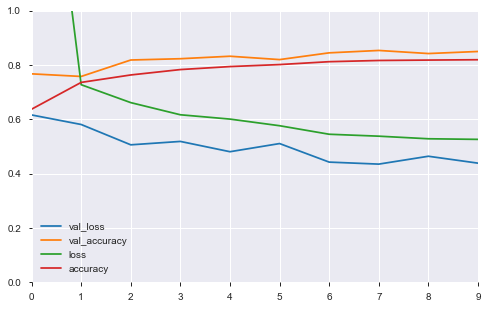

In [20]:
# curva de aprendizaje para clasificador con sklearn split
pd.DataFrame(historySplit.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Con grupo por defecto

In [21]:
# definiendo el modelo MLP de Keras
basicClassifier = Sequential(layerList)

In [22]:
# compilando las condiciones de optimizacion y ajuste del MLP Keras
basicClassifier.compile(loss = l, optimizer = opti, metrics = met)

In [23]:
# ajustando el modelo MLP Keras
historyBasic = basicClassifier.fit(
    x = np.array(X_train), 
    y = to_categorical(np.array(y_train), categories), 
    epochs = epo, verbose = ver, 
    workers = 8, use_multiprocessing = True,
    validation_data = (np.array(X_test), to_categorical(np.array(y_test), categories))
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 232us/step - loss: 0.5446 - accuracy: 0.8191 - val_loss: 0.4296 - val_accuracy: 0.8466
Epoch 2/10
60000/60000 [==============================] - 13s 221us/step - loss: 0.5156 - accuracy: 0.8235 - val_loss: 0.4384 - val_accuracy: 0.8481
Epoch 3/10
60000/60000 [==============================] - 13s 213us/step - loss: 0.5071 - accuracy: 0.8238 - val_loss: 0.4250 - val_accuracy: 0.8520
Epoch 4/10
60000/60000 [==============================] - 13s 225us/step - loss: 0.5028 - accuracy: 0.8298 - val_loss: 0.4188 - val_accuracy: 0.8563
Epoch 5/10
60000/60000 [==============================] - 14s 234us/step - loss: 0.5027 - accuracy: 0.8281 - val_loss: 0.4596 - val_accuracy: 0.8516
Epoch 6/10
60000/60000 [==============================] - 14s 236us/step - loss: 0.4937 - accuracy: 0.8291 - val_loss: 0.4361 - val_accuracy: 0.8428
Epoch 7/10
60000/60000 [==============================] 

In [24]:
# evaluando el modelo entrenado con sus propias herramientas
evalBasic = basicClassifier.evaluate(x = np.array(X_test), y = to_categorical(np.array(y_test), categories))

10000/10000 [==============================] - 2s 200us/step


In [25]:
print("Perdida: ", evalBasic[0])
print("Precision: ", evalBasic[1])

Perdida:  0.46254461250305173
Precision:  0.8425999879837036


In [26]:
# resumen de datos del MLP Keras
basicClassifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)              

In [27]:
# se prueba MLP de sklearn
basicPrediction = basicClassifier.predict(np.array(X_test))

# ajuste de las predicciones para ver el reporte de matrix de confusion
basicPrediction = np.array(basicPrediction).argmax(axis=1)

In [28]:
# Informe de los resultados para las pruebas del MLP
print("----- Reporte de Pruebas MLP con div por defecto -----")
print("--- Conteo ---\n" + str(Counter(basicPrediction)))
print("--- Matriz de Confusion ---\n" + str(confusion_matrix(y_test, basicPrediction)))
print("--- Reporte de Pruebas: ---")
print(classification_report(y_test, basicPrediction))
print("--- Puntaje ---\n")
print(" - Perdida: ", evalSplit[0])
print(" - Precision: ", evalSplit[1])

----- Reporte de Pruebas MLP con div por defecto -----
--- Conteo ---
Counter({2: 1111, 6: 1095, 3: 1084, 9: 1047, 7: 1021, 8: 958, 1: 952, 5: 934, 0: 924, 4: 874})
--- Matriz de Confusion ---
[[753   0   8  41   2   0 192   0   4   0]
 [  3 946   5  41   1   0   3   0   1   0]
 [  9   1 779  13 111   0  86   0   1   0]
 [  9   3   5 889  21   0  72   0   1   0]
 [  0   2 147  66 678   0 105   1   1   0]
 [  0   0   1   0   0 921   0  35   3  40]
 [149   0 151  29  60   0 603   0   8   0]
 [  0   0   0   0   0   7   0 952   0  41]
 [  1   0  15   5   1   1  33   5 939   0]
 [  0   0   0   0   0   5   1  28   0 966]]
--- Reporte de Pruebas: ---
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1000
           1       0.99      0.95      0.97      1000
           2       0.70      0.78      0.74      1000
           3       0.82      0.89      0.85      1000
           4       0.78      0.68      0.72      1000
           5       0.99

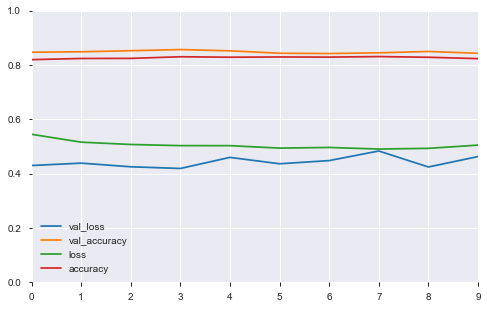

In [29]:
# curva de aprendizaje para clasificador con sklearn split
pd.DataFrame(historyBasic.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Optimización de Hiper-parámetros

para optimizar el desempeño del Perceptrón se utiliza la librería Talos porque es relativamente fácil de crear un modelo optimizable e iterable en el espacio de hiper-parámetros definiendo una función con parámetros específicos. Para lograr esto se realizan los siguientes pasos:

 - Se define una función como modelo para el modelo de optimización Talos.
 - Se define un espacio de búsqueda de hiper-parámetros del MLP.
 - Se ejecuta una búsqueda aleatoria (opción por defecto de Talos) en una fracción reducida del espacio de hiper-parámetros del MLP.
 - Después, se analizan los resultados para obtener la mejor versión del modelo entrenado y se resume los resultados del modelo seleccionado durante el proceso de optimización.

In [30]:
# redefiniendo el modelo preliminar en funcion para optimizar
def fashionPerceptron(X_train, y_train, X_test, y_test, params):
  
    inshape = X_train[0].shape
    lshape = np.reshape(X_train[0], -1).shape
    ver = 0
    
    # definiendo el modelo MLP de Keras
    model = Sequential()
    
    # capa para representacion alternativa de (n,m) a (m*m)
    model.add(Flatten(input_shape = X_train[0].shape))

    # capa de entrada para el modelo
    model.add(Dense(params["first_neuron"], input_shape = inshape, activation = params["activation"]))
    
    # paso intermedio para hacer dropout yevitar overfit
    model.add(Dropout(params["dropout"]))
    
    # capas ocultas del modelo
    for i in range(params['hidden_layers']):
        model.add(Dense(params['hidden_neuron'], input_shape = lshape, activation = params["activation"])),
        model.add(Dropout(params['dropout']))
    
    # capa de salida del modelo
    model.add(Dense(params["last_neuron"], input_shape = lshape, activation = params["last_activation"]))
    
    # compilando las condiciones de optimizacion y ajuste del MLP Keras
    model.compile(optimizer = params["optimizer"], loss = params["losses"], metrics = ["acc"])

    # entrenando el modelo MLP Keras
    history = model.fit(
        x = np.array(X_train), 
        y = to_categorical(np.array(y_train), params["last_neuron"]), 
        epochs = params["epochs"], verbose = ver, 
        workers = 8, use_multiprocessing = True,
        batch_size = params["batch_size"],
        callbacks = [talos.utils.ExperimentLogCallback("fashionPerceptronExp", params)],
        validation_data = (np.array(X_test), to_categorical(np.array(y_test), params["last_neuron"]))
    )
    
    return history, model

In [31]:
# espacio de optimizacion de hyperparametros para el MLP
parameters = {"activation": ["relu", "elu"],
     "last_activation": ["softmax"],
     "optimizer": ["Nadam", "Adam"],
     "losses": ["categorical_crossentropy"],
     "shapes": ["brick"],
     "first_neuron": [100, 200, 300],
     "hidden_neuron": [100, 200, 300],
     "last_neuron": [len(classNamesList)],
     "hidden_layers": [0, 1, 2, 3],
     "dropout": [.1, .2, .3],
     "batch_size": [32, 64, 128],
     "epochs": [10]}

In [32]:
# se hace la busqueda con la funcion Scan()
# se utiliza el conjunto de datos reorganizado con sklearn
# la semilla random es 42 porque es la respuesta universal y es la misma en todo el codigo
# por defecto Talos hace una busqueda random, en general es mejor aunque puede caer en minimos/maximos locales
# la poblacion de busqueda aleatoria es de un 1.0% ~ 3.0% para que el procedimiento sea rapido
# para acelerar el proceso se prueba con reduction_method con correlacion y ajustandolo contra la precision de validacion
scanPerceptron = talos.Scan(x = X_trainB, y = y_trainB,
                            x_val = X_testB, y_val = y_testB,
                            model = fashionPerceptron,
                            experiment_name = "fashionPerceptronExp",
                            params = parameters, 
                            reduction_method = "correlation",
                            reduction_metric = "val_acc",
                            fraction_limit = 0.03,
                            seed = 42,
                            print_params = True)

  0%|                                                                                        | 0/38 [00:00<?, ?it/s]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 0, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


  3%|██                                                                              | 1/38 [01:28<54:16, 88.02s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 3, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


  5%|████                                                                         | 2/38 [07:57<1:47:04, 178.45s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 1, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


  8%|██████                                                                       | 3/38 [10:35<1:40:32, 172.35s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 0, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 11%|████████                                                                     | 4/38 [12:32<1:28:17, 155.81s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 1, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 13%|██████████▏                                                                  | 5/38 [14:11<1:16:12, 138.57s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 0, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 16%|████████████▏                                                                | 6/38 [18:17<1:31:10, 170.95s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 2, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 18%|██████████████▏                                                              | 7/38 [20:02<1:18:08, 151.24s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 0, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 21%|████████████████▏                                                            | 8/38 [22:49<1:17:51, 155.71s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 3, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 24%|██████████████████▏                                                          | 9/38 [28:36<1:43:05, 213.30s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 3, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 26%|████████████████████                                                        | 10/38 [30:02<1:21:42, 175.11s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 1, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 29%|██████████████████████                                                      | 11/38 [31:37<1:07:57, 151.02s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 0, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 32%|████████████████████████▋                                                     | 12/38 [31:54<47:59, 110.75s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 2, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 34%|███████████████████████████                                                    | 13/38 [32:44<38:35, 92.63s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 1, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 37%|█████████████████████████████                                                  | 14/38 [33:04<28:15, 70.65s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 1, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 39%|███████████████████████████████▏                                               | 15/38 [33:56<25:02, 65.33s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 1, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 42%|█████████████████████████████████▎                                             | 16/38 [34:28<20:13, 55.16s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 3, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 45%|███████████████████████████████████▎                                           | 17/38 [36:22<25:28, 72.80s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 2, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 47%|█████████████████████████████████████▍                                         | 18/38 [37:09<21:43, 65.18s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 0, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 50%|███████████████████████████████████████▌                                       | 19/38 [37:38<17:10, 54.26s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 2, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 53%|█████████████████████████████████████████▌                                     | 20/38 [38:21<15:18, 51.01s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 3, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 55%|███████████████████████████████████████████▋                                   | 21/38 [39:12<14:26, 50.95s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 1, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 58%|█████████████████████████████████████████████▋                                 | 22/38 [39:36<11:25, 42.85s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 1, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 61%|███████████████████████████████████████████████▊                               | 23/38 [40:18<10:40, 42.68s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 3, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 63%|█████████████████████████████████████████████████▉                             | 24/38 [40:46<08:52, 38.01s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 1, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 66%|███████████████████████████████████████████████████▉                           | 25/38 [41:54<10:12, 47.12s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 2, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 68%|██████████████████████████████████████████████████████                         | 26/38 [42:39<09:18, 46.57s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 1, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 71%|████████████████████████████████████████████████████████▏                      | 27/38 [43:26<08:33, 46.71s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 1, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 74%|██████████████████████████████████████████████████████████▏                    | 28/38 [44:56<09:55, 59.58s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 2, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 76%|████████████████████████████████████████████████████████████▎                  | 29/38 [46:15<09:49, 65.51s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 200, 'hidden_layers': 1, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 79%|██████████████████████████████████████████████████████████████▎                | 30/38 [46:56<07:44, 58.09s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 3, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 82%|████████████████████████████████████████████████████████████████▍              | 31/38 [47:28<05:51, 50.18s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 1, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 84%|██████████████████████████████████████████████████████████████████▌            | 32/38 [48:00<04:29, 44.91s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 3, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 87%|████████████████████████████████████████████████████████████████████▌          | 33/38 [49:19<04:35, 55.13s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 2, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 89%|██████████████████████████████████████████████████████████████████████▋        | 34/38 [50:49<04:21, 65.49s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 3, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 92%|████████████████████████████████████████████████████████████████████████▊      | 35/38 [51:25<02:50, 56.80s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 3, 'hidden_neuron': 200, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 95%|██████████████████████████████████████████████████████████████████████████▊    | 36/38 [52:37<02:02, 61.14s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 300, 'hidden_layers': 2, 'hidden_neuron': 300, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 97%|████████████████████████████████████████████████████████████████████████████▉  | 37/38 [53:19<00:55, 55.42s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 100, 'hidden_layers': 3, 'hidden_neuron': 100, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


100%|███████████████████████████████████████████████████████████████████████████████| 38/38 [53:47<00:00, 84.93s/it]


### Accediendo a los resultados del proceso de Optimización

In [33]:
# mirando los resultados de la optimizacion con dataFrame
scanPerceptron.data.head()

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,last_activation,last_neuron,losses,optimizer,shapes
0,10,0.506374,0.841571,0.612387,0.777464,elu,128,0.3,10,200,0,200,softmax,10,categorical_crossentropy,Adam,brick
1,10,0.661314,0.724929,0.753906,0.704268,relu,32,0.2,10,300,3,100,softmax,10,categorical_crossentropy,Nadam,brick
2,10,0.594900,0.754071,0.722038,0.706714,elu,64,0.3,10,200,1,100,softmax,10,categorical_crossentropy,Adam,brick
3,10,0.658638,0.773571,0.777002,0.708411,elu,64,0.2,10,100,0,100,softmax,10,categorical_crossentropy,Nadam,brick
4,10,0.625690,0.740214,0.830353,0.681232,relu,128,0.3,10,300,1,300,softmax,10,categorical_crossentropy,Nadam,brick


In [34]:
# mirando la entropia de cada ronda de experimentos
scanPerceptron.learning_entropy.head()

,loss,acc
0,0.197569,0.000379
1,0.016715,0.001064
2,0.132008,0.002163
3,0.080779,0.000344
4,0.106629,0.000505


In [35]:
# tipos de datos dentro del set de resultados
scanPerceptron.data.dtypes

round_epochs         int64
val_loss           float64
val_acc            float64
loss               float64
acc                float64
activation          object
batch_size           int64
dropout            float64
epochs               int64
first_neuron         int64
hidden_layers        int64
hidden_neuron        int64
last_activation     object
last_neuron          int64
losses              object
optimizer           object
shapes              object
dtype: object

In [36]:
# # ver los modelos que se probaron en el proceso de optimizavion
# scanPerceptron.saved_models
    
# # ver los pesos de los modelos probados en el proceso de optimizacion
# scanPerceptron.saved_weights

# resumen del proceso de optimizacion realizado
scanPerceptron.details

experiment_name        fashionPerceptronExp
random_method              uniform_mersenne
reduction_method                correlation
reduction_interval                       50
reduction_window                         20
reduction_threshold                     0.2
reduction_metric                    val_acc
complete_time                11/29/19/15:35
x_shape                                list
y_shape                                list
dtype: object

### Analizando los resultados del proceso de Optimización
Se hacen diferentes graficas para tener perspectivas diferentes en el análisis de los resultados de la búsqueda con Talos.

In [37]:
# para el analisis se utiliza el reporte creado por Talos como entrada de Analyze
analyzePerceptron = talos.Analyze(scanPerceptron)

In [38]:
# acceso al DataFrame del analisis del reporte
analyzePerceptron.data

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,last_activation,last_neuron,losses,optimizer,shapes
0,10,0.506374,0.841571,0.612387,0.777464,elu,128,0.3,10,200,0,200,softmax,10,categorical_crossentropy,Adam,brick
1,10,0.661314,0.724929,0.753906,0.704268,relu,32,0.2,10,300,3,100,softmax,10,categorical_crossentropy,Nadam,brick
2,10,0.594900,0.754071,0.722038,0.706714,elu,64,0.3,10,200,1,100,softmax,10,categorical_crossentropy,Adam,brick
3,10,0.658638,0.773571,0.777002,0.708411,elu,64,0.2,10,100,0,100,softmax,10,categorical_crossentropy,Nadam,brick
4,10,0.625690,0.740214,0.830353,0.681232,relu,128,0.3,10,300,1,300,softmax,10,categorical_crossentropy,Nadam,brick
5,10,0.595928,0.795500,0.720555,0.757429,elu,32,0.2,10,200,0,100,softmax,10,categorical_crossentropy,Adam,brick
6,10,0.900852,0.649214,1.054143,0.567161,relu,128,0.3,10,100,2,100,softmax,10,categorical_crossentropy,Adam,brick
7,10,0.498431,0.837143,0.508863,0.820500,relu,64,0.1,10,300,0,300,softmax,10,categorical_crossentropy,Adam,brick
8,10,0.445998,0.844214,0.459256,0.844054,elu,32,0.1,10,200,3,300,softmax,10,categorical_crossentropy,Adam,brick
9,10,0.580566,0.742000,0.655127,0.733214,elu,32,0.3,10,300,3,100,softmax,10,categorical_crossentropy,Adam,brick


In [39]:
# numero de experimentos realizados
analyzePerceptron.rounds()

38

In [40]:
# se recupera el numero del modelo con mejor puntaje, en este caso es la precision de pruetas/validacion "val_acc"
analyzePerceptron.high("val_acc")

0.8705000281333923

In [41]:
# get the round with the best result
analyzePerceptron.rounds2high("val_acc")

20

In [42]:
# imprime los mejores parametros encontrados en el proceso de optimizacion
analyzePerceptron.best_params("val_acc", ["acc", "loss", "val_loss"])

array([['brick', 300, 'softmax', 3, 128, 10, 10, 10, 'Nadam', 'relu',
        300, 'categorical_crossentropy', 0.1, 0],
       ['brick', 100, 'softmax', 3, 128, 10, 10, 10, 'Nadam', 'elu', 100,
        'categorical_crossentropy', 0.1, 1],
       ['brick', 200, 'softmax', 1, 128, 10, 10, 10, 'Nadam', 'relu',
        100, 'categorical_crossentropy', 0.1, 2],
       ['brick', 200, 'softmax', 1, 64, 10, 10, 10, 'Nadam', 'elu', 100,
        'categorical_crossentropy', 0.1, 3],
       ['brick', 200, 'softmax', 2, 64, 10, 10, 10, 'Adam', 'elu', 100,
        'categorical_crossentropy', 0.1, 4],
       ['brick', 200, 'softmax', 3, 32, 10, 10, 10, 'Adam', 'elu', 300,
        'categorical_crossentropy', 0.1, 5],
       ['brick', 200, 'softmax', 0, 128, 10, 10, 10, 'Adam', 'elu', 200,
        'categorical_crossentropy', 0.3, 6],
       ['brick', 300, 'softmax', 0, 64, 10, 10, 10, 'Adam', 'relu', 300,
        'categorical_crossentropy', 0.1, 7],
       ['brick', 100, 'softmax', 3, 32, 10, 10, 10, '

In [43]:
# correlacion entre el puntaje y el resto de los hyperparametros
analyzePerceptron.correlate("val_loss", ["acc", "loss", "val_loss"])

round_epochs          NaN
val_acc         -0.944578
batch_size      -0.178436
dropout          0.614128
epochs                NaN
first_neuron    -0.232673
hidden_layers   -0.128565
hidden_neuron   -0.035637
last_neuron           NaN
Name: val_loss, dtype: float64

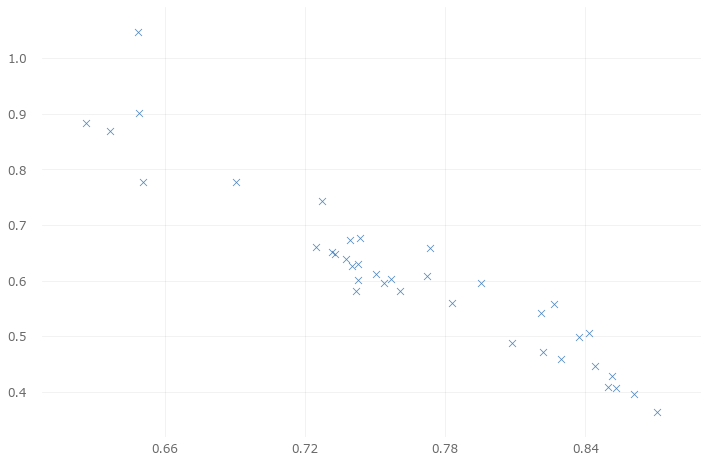

In [44]:
# a regression entre precision de puntaje/precision y perdida del conjunto de preubas
analyzePerceptron.plot_regs("val_acc", "val_loss")

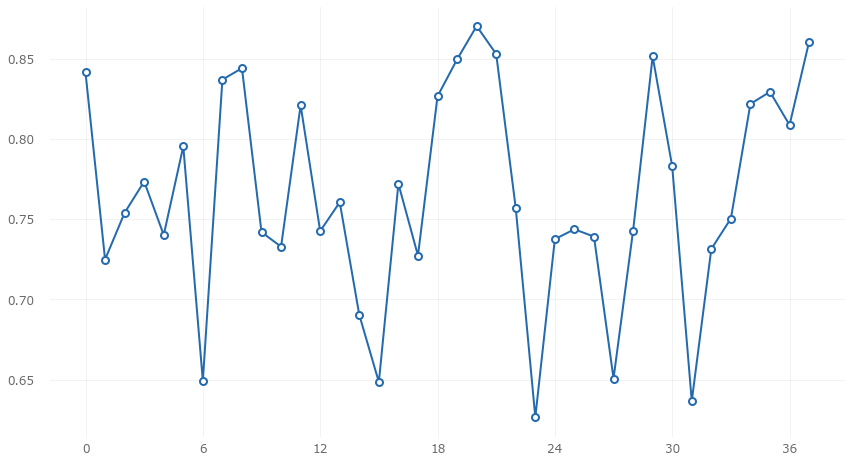

In [45]:
# linea de resultados de la precision de los experimentos
analyzePerceptron.plot_line("val_acc")

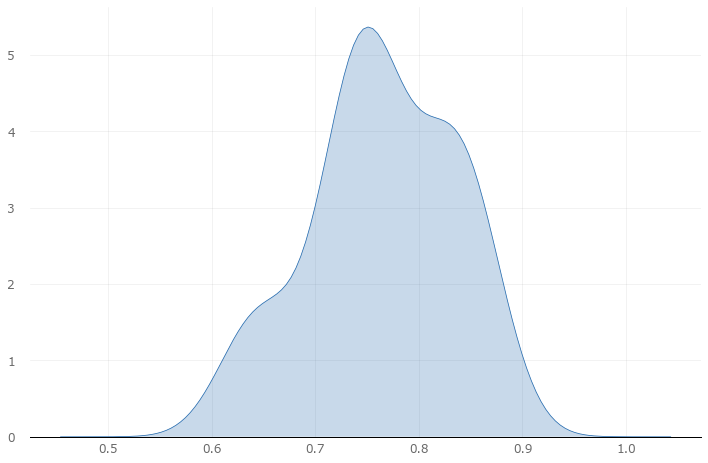

In [46]:
# distribucion de probabilidad de la precision de pruebas
analyzePerceptron.plot_kde("val_acc")

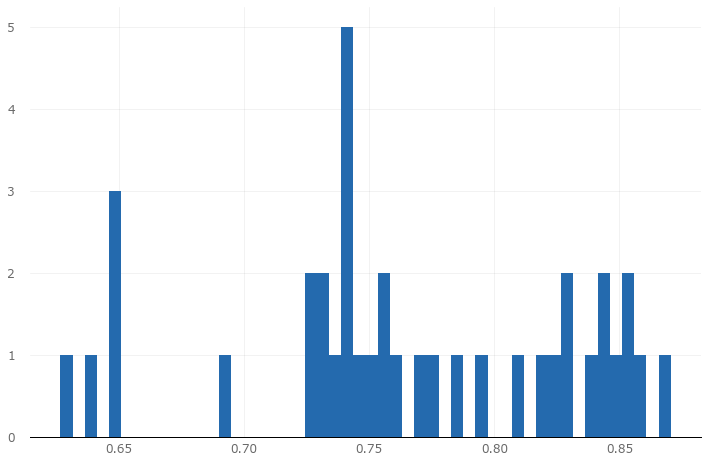

In [47]:
# histograma de la precision de pruebas de los experimentso
analyzePerceptron.plot_hist("val_acc", bins = 50)

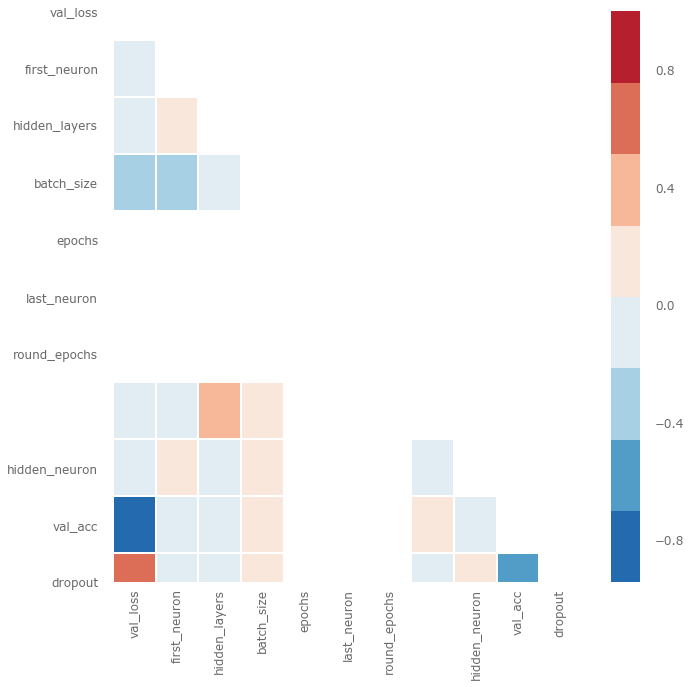

In [48]:
# mapa de correlacion para la correlacion de de la precision de preubas y otras variables
analyzePerceptron.plot_corr("val_loss", ["acc", "loss", "val_loss"])

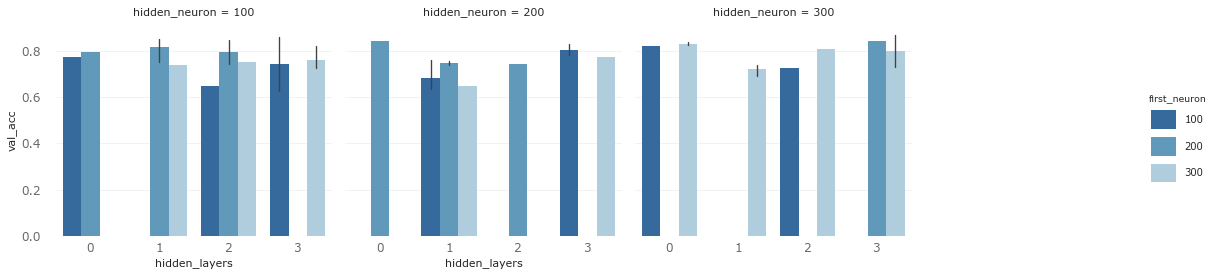

In [49]:
# grafica analizando el comportamiento de las capas ocultas, precision de pruebas, # de neuroans en la entrada y # de neuronas en la capa escondida
analyzePerceptron.plot_bars("hidden_layers", "val_acc", "first_neuron", "hidden_neuron")

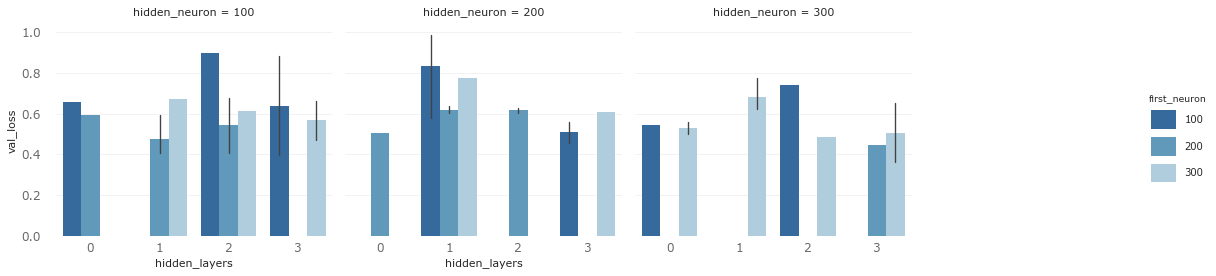

In [50]:
# grafica analizando el comportamiento de las capas ocultas, precision de pruebas, # de neuroans en la entrada y # de neuronas en la capa escondida
analyzePerceptron.plot_bars("hidden_layers", "val_loss", "first_neuron", "hidden_neuron")

### Evaluando finalmente el Modelo
por defecto Talos si no se indica el ID del modelo para evaluar, escoge el mejor.

In [51]:
# creando el objeto para evaluar con Talos
evaluatePerceptron = talos.Evaluate(scanPerceptron)

In [52]:
# evaluacion final de los datos con el mejor modelo
bestAcc = evaluatePerceptron.evaluate(np.array(X_testB), to_categorical(np.array(y_testB)), folds = 5, metric = "val_acc", task = "multi_label")

In [53]:
# resumen basico del mejor MLP
evaluatePerceptron.scan_object.best_model(metric='val_acc').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)              

In [54]:
# configuracion especifica del mejor MLP
evaluatePerceptron.scan_object.best_model(metric='val_acc').get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Flatten',
   'config': {'name': 'flatten_1',
    'trainable': True,
    'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'data_format': 'channels_last'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'units': 300,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.1,
    'noise_shape': None,
    'seed': None}},


### Predicciones y Análisis detallado del mejor Modelo

In [55]:
# predecir resultados con el mejor modelo
predictPerceptron = talos.Predict(scanPerceptron, task = "multi_label")

In [56]:
# se prueba MLP de sklearn
bestPrediction = predictPerceptron.predict(np.array(X_testB))

# ajuste de las predicciones para ver el reporte de matrix de confusion
bestPrediction = np.array(bestPrediction).argmax(axis=1)

In [57]:
# Informe de los resultados para las pruebas del MLP
print("----- Reporte FINAL de Pruebas MLP -----")
print("--- Conteo ---\n" + str(Counter(bestPrediction)))
print("--- Matriz de Confusion ---\n" + str(confusion_matrix(y_testB, bestPrediction)))
print("--- Reporte de Pruebas: ---")
print(classification_report(y_testB, bestPrediction))
print("--- Puntaje ---\n")
print(" - Precision: ", str(bestAcc))
print(" - Precision Promedio: ", str(np.mean(bestAcc)))

----- Reporte FINAL de Pruebas MLP -----
--- Conteo ---
Counter({0: 1573, 9: 1545, 3: 1521, 4: 1480, 2: 1389, 5: 1387, 1: 1382, 8: 1332, 7: 1318, 6: 1073})
--- Matriz de Confusion ---
[[1209    1   23   71    4    2   75    0    9    0]
 [   6 1364    2   22    1    1    5    0    1    0]
 [  13    1 1119   20  185    2   64    0    3    0]
 [  34   10    8 1302   64    0   27    0    3    1]
 [   3    1   93   43 1110    0  104    0    3    0]
 [   1    0    0    2    0 1357    0   47    5   37]
 [ 307    3  135   56  112    1  783    0   10    0]
 [   0    0    0    0    0    8    0 1246    2  103]
 [   0    2    9    5    4    3   15    5 1296    3]
 [   0    0    0    0    0   13    0   20    0 1401]]
--- Reporte de Pruebas: ---
              precision    recall  f1-score   support

           0       0.77      0.87      0.81      1394
           1       0.99      0.97      0.98      1402
           2       0.81      0.80      0.80      1407
           3       0.86      0.90      0

# Conclusiones 

Antes de entrenar cuando se cargan los datos, aunque no es absolutamente necesario, se crea un DataFrame de Pandas para facilitar la lectura y el reusó. Se guarda la forma y otros valores de posible interés en el momento de entrenamiento. Al utilizar la división aleatoria para entrenar el modelo preliminar se ve un contraste marcado en la curva de aprendizaje, en donde se observa un comportamiento convergente tradicional entre la precisión/perdida en pruebas y entrenamiento. Por su parte, el comportamiento del conjunto de datos organizados por defecto muestra un comportamiento casi paralelo entre y estable de la precisión/perdida lo cual indica un modelo sub ajustado. Esto último valida la decisión de utilizar una división aleatoria del conjunto de datos y la creación de un DataFrame aunque su rendimiento/perdida nominal no sean significativamente diferentes.

En el entrenamiento preliminar se observa que ambos modelos tienen un buen comportamiento global, pero en las clases se observa que las categorías 0, 2, 4 y 6 tienen menos precisión y en general se confunden entre ellas. Al ver los datos y los nombres de las clases se reconoce que estas clases son “T-shirt/top”/camiseta, “Pullover”/buso, “Coat”/chaqueta, “Shirt”/camisa respectivamente. Esto en si da a ver que las clases son realmente similares y parecidas entre si y que una mala distribución de datos afecta el rendimiento del modelo al momento de reconocer las clases. 

Después de este entrenamiento preliminar siempre se escogerá una distribución aleatoria para la optimización y los otros puntos del taller como distribución por defecto para los datos.

En la optimización de hiper-parámetros se utiliza la librería por extensión Talos por su facilidad al transformar las especificaciones del modelo preliminar en modelos candidatos durante una búsqueda aleatoria de los mejores hiper-parámetros. La búsqueda se hace aleatoria, con la precisión como parámetro objetivo a maximizar y con una población de máximo 3% para no cargar de tantos datos el proceso. En general se configura la búsqueda para minimizar el uso de parámetros/hiper-parámetros no significativos (correlacionados linealmente) con la precisión del modelo.

El modelo final optimizado es un MLP con:

-	Una capa de entrada “Flatten” que recibe la imagen 2D y lo transforma a un arreglo 1D para facilidad de procesamiento.
-	Una capa de 300 neuronas “Dense” como capa de entrada para los datos y activación tipo “elu”
-	Entre capas de trabajo “Dropout” con 10% de desactivación para evitar sobreajustes.
-	Una capa de 200 neuronas “Dense” como capa como primera capa de aprendizaje y activación tipo “elu”.
-	Una capa de 200 neuronas “Dense” como capa como segunda capa de aprendizaje y activación tipo “elu”.
-	Una capa con 10 neuronas “Dense” como capa de salida para clasificación con función de activación “softmax” para reconocer categorías por separado.

La búsqueda muestra una correlación fuerte entre la precisión y la perdida de tendencia lineal, lo que coincide con la literatura. La precisión tiene un mínimo de 35% y un máximo de 86% (optimo encontrado). En promedio el rendimiento (precisión) de los modelos esta alrededor 78%. También se observa una correlación entre el tamaño de la muestra lo cual muestra que es una opción viable para agilizar el entrenamiento. Otra correlación está en los valores de número de capas ocultas y neuronas dentro de ellas, lo cual soporta la idea que se necesitan más capas de aprendizaje para distinguir las diferencias entre las clases confusas (0, 2, 4 y 6). Por último, el Dropout también se observa la correlación al evitar el sobreajuste.